<a href="https://colab.research.google.com/github/Saravanan-Manish/google-colab/blob/main/BTP_2_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install do-mpc[full]
# !apt-get install imagemagick

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.8 MB/s eta 0:00:00



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



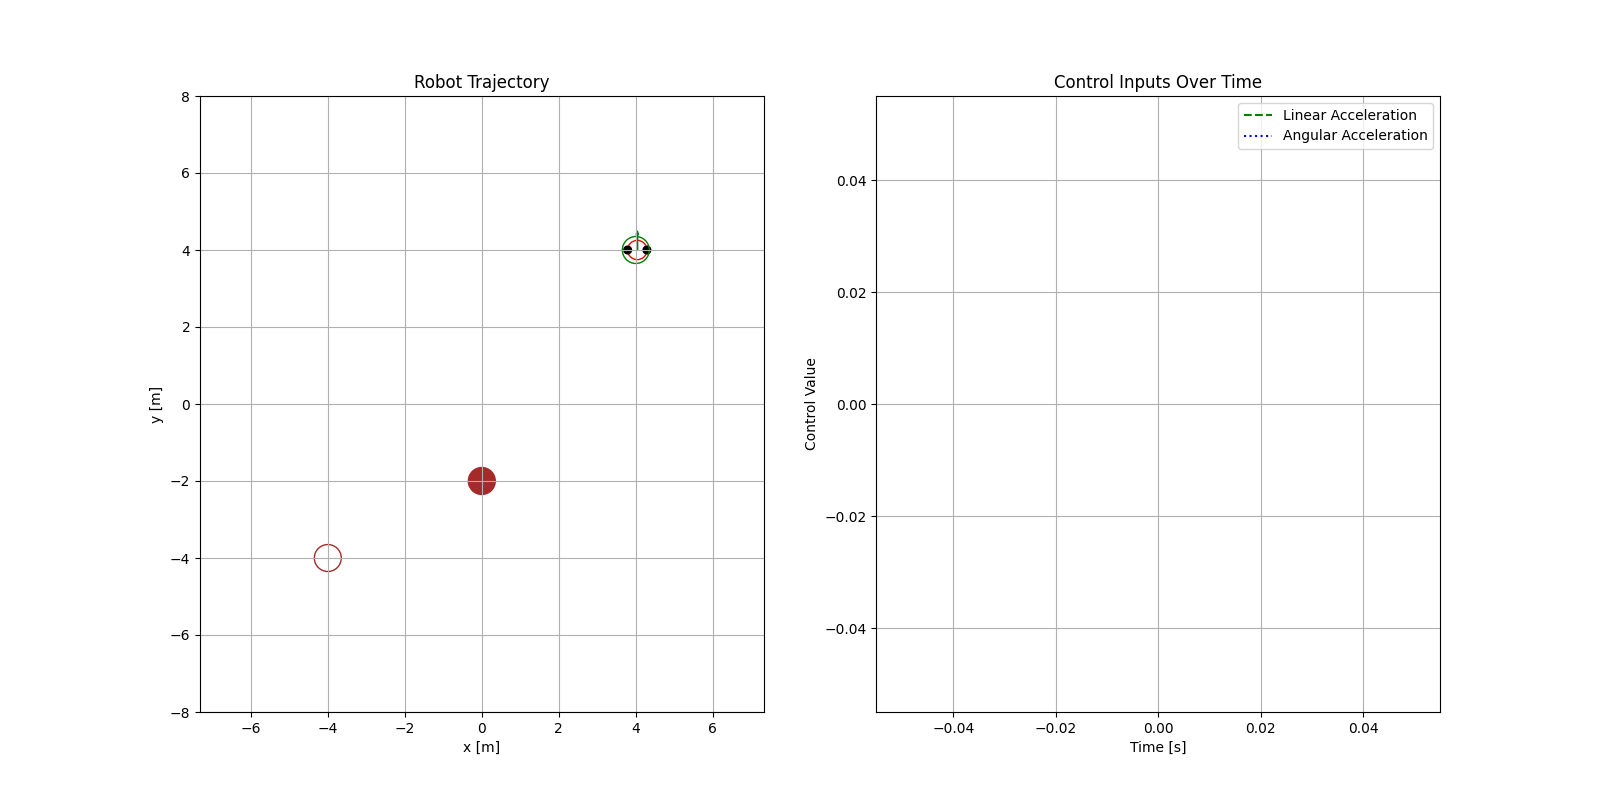

In [2]:
import numpy as np
import sys
from casadi import *
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

# Add do-mpc to system path
rel_do_mpc_path = os.path.join('..', '..', '..')
sys.path.append(rel_do_mpc_path)
import do_mpc

# Model type and initialization
model_type = 'continuous'
model = do_mpc.model.Model(model_type)

# Robot parameters
r = 0.1  # m, wheel radius
L = 0.5  # m, distance between wheels
m = 1.0  # kg, mass of the robot
I = 0.1  # kg.m^2, moment of inertia

robot_radius = L/2

# State variables
x = model.set_variable('_x', 'x')  # x-position
y = model.set_variable('_x', 'y')  # y-position
theta = model.set_variable('_x', 'theta')  # orientation
v = model.set_variable('_x', 'v')  # linear velocity
omega = model.set_variable('_x', 'omega')  # angular velocity

# Control inputs
u_v = model.set_variable('_u', 'u_v')  # acceleration
u_omega = model.set_variable('_u', 'u_omega')  # angular acceleration

# Start and end states
start = np.array([-4.0, -4.0, 0.0, 0.0, 0.0])
goal = np.array([4.0, 4.0, np.pi/2])

# Obstacle parameters
obstacle_radius = L/2 + r
safe_gap = 0.2
obstacle_x = 0
obstacle_y = -2

# Add noise to the obstacle's state estimation
obstacle_noise_std = 0.1
obstacle_x_est = obstacle_x # + np.random.normal(0, obstacle_noise_std)
obstacle_y_est = obstacle_y # + np.random.normal(0, obstacle_noise_std)

# Differential drive dynamics
model.set_rhs('x', v * cos(theta))
model.set_rhs('y', v * sin(theta))
model.set_rhs('theta', omega)
model.set_rhs('v', u_v)
model.set_rhs('omega', u_omega)

# # Cost function (minimize distance to goal, control effort, and avoid obstacle)
# goal = np.array([4.0, 4.0, np.pi/2])  # Goal state: [x, y, theta]
# pos_err = np.sqrt((x - goal[0])**2 + (y - goal[1])**2)
# mterm = pos_err + (0.1/(pos_err+1e-6))*(theta - goal[2])**2
# lterm = mterm + 0.2*(0.2*u_v**2 + u_omega**2)

# Cost function (minimize distance to goal, control effort, and avoid obstacle)
pos_err = (x - goal[0])**2 + (y - goal[1])**2
mterm = pos_err + (theta - goal[2])**2
lterm = mterm + 0.2*(0.2*u_v**2 + u_omega**2)

model.set_expression('mterm', mterm)
model.set_expression('lterm', lterm)

distance_to_obstacle = np.sqrt((x - obstacle_x_est)**2 + (y - obstacle_y_est)**2) - (obstacle_radius + robot_radius)
model.set_expression('distance_to_obstacle', distance_to_obstacle)

# Build the model
model.setup()

# MPC controller setup
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 50,
    't_step': 0.1,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 2,
    'store_full_solution': True,
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps', 'ipopt.print_level': 0, 'print_time': 0}
}

mpc.set_param(**setup_mpc)
mpc.set_objective(mterm=model.aux['mterm'], lterm=model.aux['lterm'])
mpc.set_rterm(u_v=0.5, u_omega=0.0)

# Control input bounds
mpc.bounds['lower', '_u', 'u_v'] = -2.5
mpc.bounds['upper', '_u', 'u_v'] = 2.5
mpc.bounds['lower', '_u', 'u_omega'] = -1.0
mpc.bounds['upper', '_u', 'u_omega'] = 1.0

# Add nonlinear constraint: distance from the obstacle
mpc.set_nl_cons('radius_constraint', -model.aux['distance_to_obstacle'], -safe_gap)

mpc.setup()

# Estimator and simulator setup
estimator = do_mpc.estimator.StateFeedback(model)

simulator = do_mpc.simulator.Simulator(model)
params_simulator = {'integration_tool': 'idas', 'abstol': 1e-8, 'reltol': 1e-8, 't_step': 0.1}
simulator.set_param(**params_simulator)
simulator.setup()

# Initial conditions
x0 = start
simulator.x0 = x0
mpc.x0 = x0
estimator.x0 = x0
mpc.set_initial_guess()

# Plotting setup
plt.ion()
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

distance_data = []

# Animation function
def update_plot(t_ind):

    x_data = mpc.data['_x', 'x'][:t_ind]
    y_data = mpc.data['_x', 'y'][:t_ind]

    ax1.plot(x_data, y_data, 'b--', lw=1)
    ax1.set_xlabel('x [m]')
    ax1.set_ylabel('y [m]')
    ax1.set_title('Robot Trajectory')
    ax1.axis('equal')
    ax1.set_xlim(-8, 8)
    ax1.set_ylim(-8, 8)
    ax1.grid(True)

    u_v_data = mpc.data['_u', 'u_v'][:t_ind]
    u_omega_data = mpc.data['_u', 'u_omega'][:t_ind]

    ax2.plot(np.arange(t_ind) * setup_mpc['t_step'], u_v_data, 'g--', lw=1.5)
    ax2.plot(np.arange(t_ind) * setup_mpc['t_step'], u_omega_data, 'b:', lw=1.5)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Control Value')
    ax2.set_title('Control Inputs Over Time')
    ax2.legend(['Linear Acceleration', 'Angular Acceleration'])
    ax2.grid(True)

    # Remove previous patches for the robot and wheels
    for c in ax1.patches:
        c.remove()

    # Current robot position and orientation
    x = mpc.data['_x', 'x'][t_ind-1]
    y = mpc.data['_x', 'y'][t_ind-1]
    theta = mpc.data['_x', 'theta'][t_ind-1]

    robot_circle = plt.Circle((x, y), L/2, color='red', fill=False)
    ax1.add_patch(robot_circle)

    left_wheel_center = (x - L/2 * np.sin(theta), y + L/2 * np.cos(theta))
    right_wheel_center = (x + L/2 * np.sin(theta), y - L/2 * np.cos(theta))

    left_wheel = plt.Circle(left_wheel_center, r, color='black', fill=True)
    right_wheel = plt.Circle(right_wheel_center, r, color='black', fill=True)

    ax1.add_patch(left_wheel)
    ax1.add_patch(right_wheel)

    heading_length = L
    ax1.add_patch(plt.Arrow(x, y, heading_length * np.cos(theta), heading_length * np.sin(theta), width=0.1, color='green'))

    # Start and goal markers
    start_circle = plt.Circle((start[0], start[1]), (L/2 + r), color='brown', fill=False)
    ax1.add_patch(start_circle)
    goal_circle = plt.Circle((goal[0], goal[1]), (L/2 + r), color='green', fill=False)
    ax1.add_patch(goal_circle)

    # Draw obstacle
    obstacle_circle = plt.Circle((obstacle_x_est, obstacle_y_est), obstacle_radius, color='brown', fill=True)
    ax1.add_patch(obstacle_circle)

    # Plot the distance from obstacle
    current_distance = mpc.data['_aux', 'distance_to_obstacle'][t_ind-1]
    distance_data.append(current_distance)

    # # Plot distance over time
    # ax2.plot(np.arange(len(distance_data)) * setup_mpc['t_step'], [safe_gap] * len(distance_data), 'r-', lw=1.5)
    # ax2.plot(np.arange(len(distance_data)) * setup_mpc['t_step'], distance_data, 'g-', lw=1.5)
    # ax2.set_xlabel('Time [s]')
    # ax2.set_ylabel('Distance to Obstacle [m]')
    # ax2.set_title('Distance to Obstacle Over Time')
    # ax2.legend(['Safe Gap', 'Distance to Obstacle'])
    # ax2.grid(True)

    # Update plot with results
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.reset_axes()

# Run the simulation
n_steps = 100
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

# Create and save animation
ani = animation.FuncAnimation(fig, update_plot, frames=n_steps, repeat=False, interval=100)
ani.save('robot_mpc.gif')

# Display animation in IPython environment
with open('robot_mpc.gif', 'rb') as f:
    display(Image(data=f.read(), format='gif'))

plt.close()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



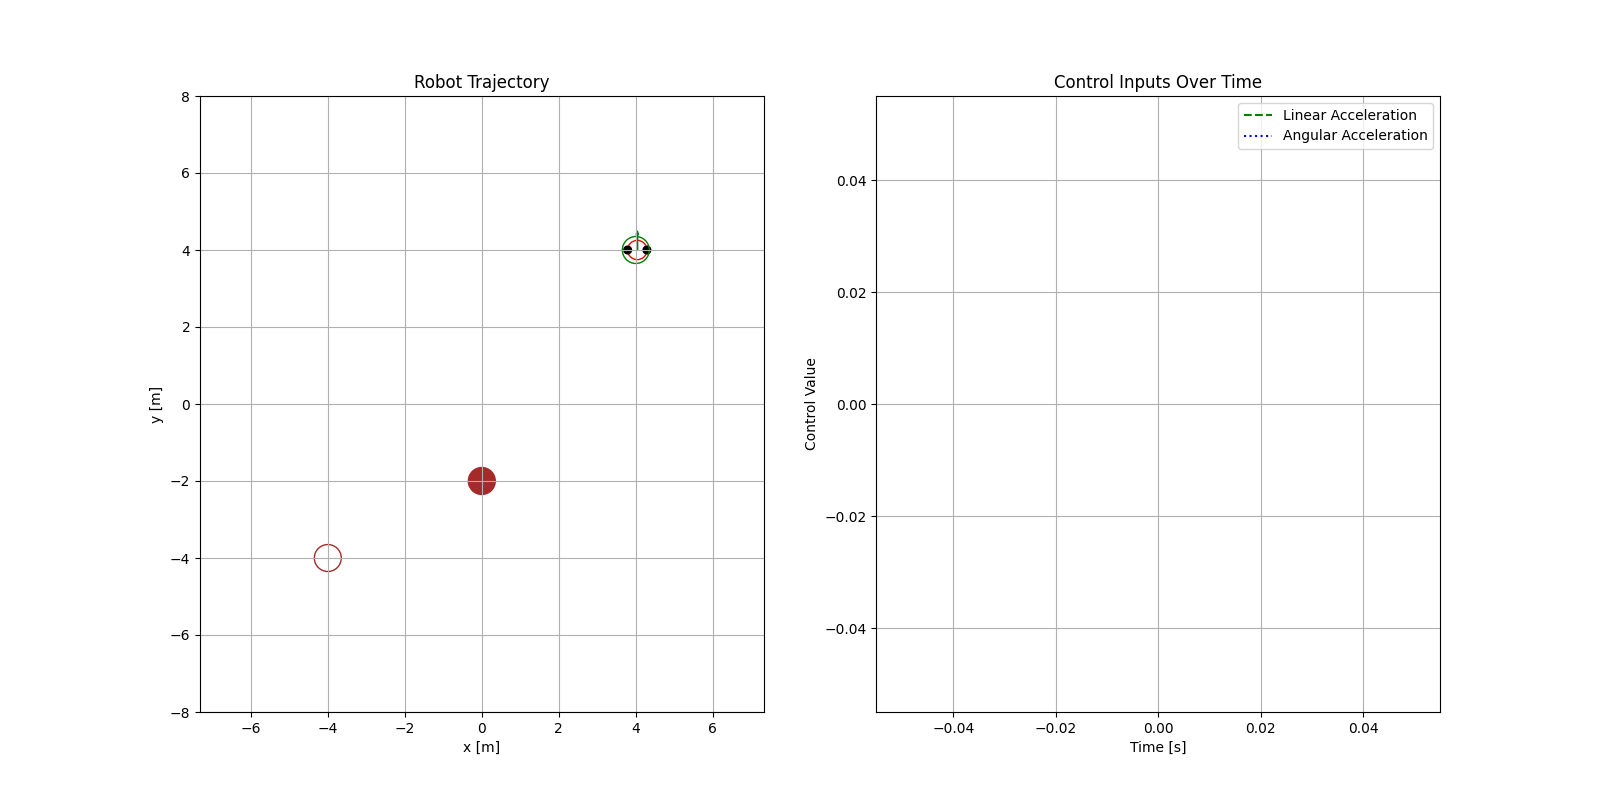

In [ ]:
import numpy as np
import sys
from casadi import *
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

# Add do-mpc to system path
rel_do_mpc_path = os.path.join('..', '..', '..')
sys.path.append(rel_do_mpc_path)
import do_mpc

# Model type and initialization
model_type = 'continuous'
model = do_mpc.model.Model(model_type)

# Robot parameters
r = 0.1  # m, wheel radius
L = 0.5  # m, distance between wheels
m = 1.0  # kg, mass of the robot
I = 0.1  # kg.m^2, moment of inertia

robot_radius = L/2

# State variables
x = model.set_variable('_x', 'x')  # x-position
y = model.set_variable('_x', 'y')  # y-position
theta = model.set_variable('_x', 'theta')  # orientation
v = model.set_variable('_x', 'v')  # linear velocity
omega = model.set_variable('_x', 'omega')  # angular velocity

# Control inputs
u_v = model.set_variable('_u', 'u_v')  # acceleration
u_omega = model.set_variable('_u', 'u_omega')  # angular acceleration

# Start and end states
start = np.array([-4.0, -4.0, 0.0, 0.0, 0.0])
goal = np.array([4.0, 4.0, np.pi/2])

# Obstacle parameters
obstacle_radius = L/2 + r
safe_gap = 0.2
obstacle_x = 0
obstacle_y = -2

# Add noise to the obstacle's state estimation
obstacle_noise_std = 0.1
obstacle_x_est = obstacle_x # + np.random.normal(0, obstacle_noise_std)
obstacle_y_est = obstacle_y # + np.random.normal(0, obstacle_noise_std)

# Differential drive dynamics
model.set_rhs('x', v * cos(theta))
model.set_rhs('y', v * sin(theta))
model.set_rhs('theta', omega)
model.set_rhs('v', u_v)
model.set_rhs('omega', u_omega)

# # Cost function (minimize distance to goal, control effort, and avoid obstacle)
# goal = np.array([4.0, 4.0, np.pi/2])  # Goal state: [x, y, theta]
# pos_err = np.sqrt((x - goal[0])**2 + (y - goal[1])**2)
# mterm = pos_err + (0.1/(pos_err+1e-6))*(theta - goal[2])**2
# lterm = mterm + 0.2*(0.2*u_v**2 + u_omega**2)

# Cost function (minimize distance to goal, control effort, and avoid obstacle)
pos_err = (x - goal[0])**2 + (y - goal[1])**2
mterm = pos_err + (theta - goal[2])**2
lterm = mterm + 0.2*(0.2*u_v**2 + u_omega**2)

model.set_expression('mterm', mterm)
model.set_expression('lterm', lterm)

distance_to_obstacle = np.sqrt((x - obstacle_x_est)**2 + (y - obstacle_y_est)**2) - (obstacle_radius + robot_radius)
model.set_expression('distance_to_obstacle', distance_to_obstacle)

# Build the model
model.setup()

# MPC controller setup
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 50,
    't_step': 0.1,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 2,
    'store_full_solution': True,
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps', 'ipopt.print_level': 0, 'print_time': 0}
}

mpc.set_param(**setup_mpc)
mpc.set_objective(mterm=model.aux['mterm'], lterm=model.aux['lterm'])
mpc.set_rterm(u_v=0.5, u_omega=0.0)

# Control input bounds
mpc.bounds['lower', '_u', 'u_v'] = -2.5
mpc.bounds['upper', '_u', 'u_v'] = 2.5
mpc.bounds['lower', '_u', 'u_omega'] = -1.0
mpc.bounds['upper', '_u', 'u_omega'] = 1.0

# Add nonlinear constraint: distance from the obstacle
mpc.set_nl_cons('radius_constraint', -model.aux['distance_to_obstacle'], -safe_gap)

mpc.setup()

# Estimator and simulator setup
estimator = do_mpc.estimator.StateFeedback(model)

simulator = do_mpc.simulator.Simulator(model)
params_simulator = {'integration_tool': 'idas', 'abstol': 1e-8, 'reltol': 1e-8, 't_step': 0.1}
simulator.set_param(**params_simulator)
simulator.setup()

# Initial conditions
x0 = start
simulator.x0 = x0
mpc.x0 = x0
estimator.x0 = x0
mpc.set_initial_guess()

# Plotting setup
plt.ion()
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

distance_data = []

# Animation function
def update_plot(t_ind):

    x_data = mpc.data['_x', 'x'][:t_ind]
    y_data = mpc.data['_x', 'y'][:t_ind]

    ax1.plot(x_data, y_data, 'b--', lw=1)
    ax1.set_xlabel('x [m]')
    ax1.set_ylabel('y [m]')
    ax1.set_title('Robot Trajectory')
    ax1.axis('equal')
    ax1.set_xlim(-8, 8)
    ax1.set_ylim(-8, 8)
    ax1.grid(True)

    u_v_data = mpc.data['_u', 'u_v'][:t_ind]
    u_omega_data = mpc.data['_u', 'u_omega'][:t_ind]

    ax2.plot(np.arange(t_ind) * setup_mpc['t_step'], u_v_data, 'g--', lw=1.5)
    ax2.plot(np.arange(t_ind) * setup_mpc['t_step'], u_omega_data, 'b:', lw=1.5)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Control Value')
    ax2.set_title('Control Inputs Over Time')
    ax2.legend(['Linear Acceleration', 'Angular Acceleration'])
    ax2.grid(True)

    # Remove previous patches for the robot and wheels
    for c in ax1.patches:
        c.remove()

    # Current robot position and orientation
    x = mpc.data['_x', 'x'][t_ind-1]
    y = mpc.data['_x', 'y'][t_ind-1]
    theta = mpc.data['_x', 'theta'][t_ind-1]

    robot_circle = plt.Circle((x, y), L/2, color='red', fill=False)
    ax1.add_patch(robot_circle)

    left_wheel_center = (x - L/2 * np.sin(theta), y + L/2 * np.cos(theta))
    right_wheel_center = (x + L/2 * np.sin(theta), y - L/2 * np.cos(theta))

    left_wheel = plt.Circle(left_wheel_center, r, color='black', fill=True)
    right_wheel = plt.Circle(right_wheel_center, r, color='black', fill=True)

    ax1.add_patch(left_wheel)
    ax1.add_patch(right_wheel)

    heading_length = L
    ax1.add_patch(plt.Arrow(x, y, heading_length * np.cos(theta), heading_length * np.sin(theta), width=0.1, color='green'))

    # Start and goal markers
    start_circle = plt.Circle((start[0], start[1]), (L/2 + r), color='brown', fill=False)
    ax1.add_patch(start_circle)
    goal_circle = plt.Circle((goal[0], goal[1]), (L/2 + r), color='green', fill=False)
    ax1.add_patch(goal_circle)

    # Draw obstacle
    obstacle_circle = plt.Circle((obstacle_x_est, obstacle_y_est), obstacle_radius, color='brown', fill=True)
    ax1.add_patch(obstacle_circle)

    # Plot the distance from obstacle
    current_distance = mpc.data['_aux', 'distance_to_obstacle'][t_ind-1]
    distance_data.append(current_distance)

    # # Plot distance over time
    # ax2.plot(np.arange(len(distance_data)) * setup_mpc['t_step'], [safe_gap] * len(distance_data), 'r-', lw=1.5)
    # ax2.plot(np.arange(len(distance_data)) * setup_mpc['t_step'], distance_data, 'g-', lw=1.5)
    # ax2.set_xlabel('Time [s]')
    # ax2.set_ylabel('Distance to Obstacle [m]')
    # ax2.set_title('Distance to Obstacle Over Time')
    # ax2.legend(['Safe Gap', 'Distance to Obstacle'])
    # ax2.grid(True)

    # Update plot with results
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.reset_axes()

# Run the simulation
n_steps = 100
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

# Create and save animation
ani = animation.FuncAnimation(fig, update_plot, frames=n_steps, repeat=False, interval=100)
ani.save('robot_mpc.gif')

# Display animation in IPython environment
with open('robot_mpc.gif', 'rb') as f:
    display(Image(data=f.read(), format='gif'))

plt.close()

In [ ]:
import numpy as np
import sys
from casadi import *
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

# Add do-mpc to system path
rel_do_mpc_path = os.path.join('..', '..', '..')
sys.path.append(rel_do_mpc_path)
import do_mpc


# Moving obstacle initialization
obstacle_x_est = 0.0
obstacle_y_est = -2.0

def create_mpc_controller():
    # Model type and initialization
    model_type = 'continuous'
    model = do_mpc.model.Model(model_type)

    # Robot parameters
    r = 0.1  # m, wheel radius
    L = 0.5  # m, distance between wheels
    robot_radius = L/2

    # State variables
    x = model.set_variable('_x', 'x')
    y = model.set_variable('_x', 'y')
    theta = model.set_variable('_x', 'theta')
    v = model.set_variable('_x', 'v')
    omega = model.set_variable('_x', 'omega')

    # Control inputs
    u_v = model.set_variable('_u', 'u_v')
    u_omega = model.set_variable('_u', 'u_omega')

    # Time-varying parameters for moving obstacle
    obstacle_x = model.set_variable('_tvp', 'obstacle_x')
    obstacle_y = model.set_variable('_tvp', 'obstacle_y')

    # Dynamic equations
    model.set_rhs('x', v * cos(theta))
    model.set_rhs('y', v * sin(theta))
    model.set_rhs('theta', omega)
    model.set_rhs('v', u_v)
    model.set_rhs('omega', u_omega)

    # Obstacle parameters
    obstacle_radius = L/2 + r
    safe_gap = 0.2

    # Cost function and constraints
    distance_to_obstacle = sqrt((x - obstacle_x)**2 + (y - obstacle_y)**2) - (obstacle_radius + robot_radius)
    model.set_expression('distance_to_obstacle', distance_to_obstacle)

    goal = np.array([4.0, 4.0, np.pi/2])
    pos_err = (x - goal[0])**2 + (y - goal[1])**2
    mterm = pos_err + (theta - goal[2])**2
    lterm = mterm + 0.2*(0.2*u_v**2 + u_omega**2)
    model.set_expression('mterm', mterm)
    model.set_expression('lterm', lterm)

    model.setup()

    # MPC configuration
    mpc = do_mpc.controller.MPC(model)
    setup_mpc = {
        'n_horizon': 20,
        't_step': 0.1,
        'state_discretization': 'collocation',
        'collocation_type': 'radau',
        'collocation_deg': 2,
        'collocation_ni': 1,
        'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
    }
    mpc.set_param(**setup_mpc)

    # Set objectives and constraints
    mpc.set_objective(mterm=model.aux['mterm'], lterm=model.aux['lterm'])
    mpc.set_rterm(u_v=0.5, u_omega=0.0)
    mpc.bounds['lower','_u','u_v'] = -2.5
    mpc.bounds['upper','_u','u_v'] = 2.5
    mpc.bounds['lower','_u','u_omega'] = -1.0
    mpc.bounds['upper','_u','u_omega'] = 1.0
    mpc.set_nl_cons('obstacle', -model.aux['distance_to_obstacle'], -safe_gap, soft_constraint=True, penalty_term_cons=1e3)

    # TVP function for moving obstacle
    tvp_template_mpc = mpc.get_tvp_template()
    def tvp_fun_mpc(t_now):
        tvp_template_mpc['_tvp'] = obstacle_x_est
        tvp_template_mpc['_tvp'] = obstacle_y_est
        return tvp_template_mpc
    mpc.set_tvp_fun(tvp_fun_mpc)

    mpc.setup()
    return mpc, model

# Initialize components
mpc, model = create_mpc_controller()
simulator = do_mpc.simulator.Simulator(model)
estimator = do_mpc.estimator.StateFeedback(model)

params_simulator = {'integration_tool': 'idas', 'abstol': 1e-8, 'reltol': 1e-8, 't_step': 0.1}
simulator.set_param(**params_simulator)

tvp_template_sim = simulator.get_tvp_template()
def tvp_fun_sim(t_now):
    tvp_template_sim['obstacle_x'] = obstacle_x_est
    tvp_template_sim['obstacle_y'] = obstacle_y_est
    return tvp_template_sim
simulator.set_tvp_fun(tvp_fun_sim)

simulator.setup()

# Simulation parameters
n_steps = 100
start = np.array([-4.0, -4.0, 0.0, 0.0, 0.0])
obstacle_velocity = np.array([0.2, 0.1])  # m/s

# Initial conditions
x0 = start.copy()
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0
mpc.set_initial_guess()

# Animation function
def update_plot(t_ind):

    x_data = mpc.data['_x', 'x'][:t_ind]
    y_data = mpc.data['_x', 'y'][:t_ind]

    ax1.plot(x_data, y_data, 'b--', lw=1)
    ax1.set_xlabel('x [m]')
    ax1.set_ylabel('y [m]')
    ax1.set_title('Robot Trajectory')
    ax1.axis('equal')
    ax1.set_xlim(-8, 8)
    ax1.set_ylim(-8, 8)
    ax1.grid(True)

    u_v_data = mpc.data['_u', 'u_v'][:t_ind]
    u_omega_data = mpc.data['_u', 'u_omega'][:t_ind]

    ax2.plot(np.arange(t_ind) * setup_mpc['t_step'], u_v_data, 'g--', lw=1.5)
    ax2.plot(np.arange(t_ind) * setup_mpc['t_step'], u_omega_data, 'b:', lw=1.5)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Control Value')
    ax2.set_title('Control Inputs Over Time')
    ax2.legend(['Linear Acceleration', 'Angular Acceleration'])
    ax2.grid(True)

    # Remove previous patches for the robot and wheels
    for c in ax1.patches:
        c.remove()

    # Current robot position and orientation
    x = mpc.data['_x', 'x'][t_ind-1]
    y = mpc.data['_x', 'y'][t_ind-1]
    theta = mpc.data['_x', 'theta'][t_ind-1]

    robot_circle = plt.Circle((x, y), L/2, color='red', fill=False)
    ax1.add_patch(robot_circle)

    left_wheel_center = (x - L/2 * np.sin(theta), y + L/2 * np.cos(theta))
    right_wheel_center = (x + L/2 * np.sin(theta), y - L/2 * np.cos(theta))

    left_wheel = plt.Circle(left_wheel_center, r, color='black', fill=True)
    right_wheel = plt.Circle(right_wheel_center, r, color='black', fill=True)

    ax1.add_patch(left_wheel)
    ax1.add_patch(right_wheel)

    heading_length = L
    ax1.add_patch(plt.Arrow(x, y, heading_length * np.cos(theta), heading_length * np.sin(theta), width=0.1, color='green'))

    # Start and goal markers
    start_circle = plt.Circle((start[0], start[1]), (L/2 + r), color='brown', fill=False)
    ax1.add_patch(start_circle)
    goal_circle = plt.Circle((goal[0], goal[1]), (L/2 + r), color='green', fill=False)
    ax1.add_patch(goal_circle)

    # Draw obstacle
    obstacle_circle = plt.Circle((obstacle_x_est, obstacle_y_est), obstacle_radius, color='brown', fill=True)
    ax1.add_patch(obstacle_circle)

    # Plot the distance from obstacle
    current_distance = mpc.data['_aux', 'distance_to_obstacle'][t_ind-1]
    distance_data.append(current_distance)

    # # Plot distance over time
    # ax2.plot(np.arange(len(distance_data)) * setup_mpc['t_step'], [safe_gap] * len(distance_data), 'r-', lw=1.5)
    # ax2.plot(np.arange(len(distance_data)) * setup_mpc['t_step'], distance_data, 'g-', lw=1.5)
    # ax2.set_xlabel('Time [s]')
    # ax2.set_ylabel('Distance to Obstacle [m]')
    # ax2.set_title('Distance to Obstacle Over Time')
    # ax2.legend(['Safe Gap', 'Distance to Obstacle'])
    # ax2.grid(True)

    # Update plot with results
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.reset_axes()

# Run the simulation
for k in range(n_steps):
    # Update obstacle position
    obstacle_x_est += obstacle_velocity[0] * setup_mpc['t_step']
    obstacle_y_est += obstacle_velocity[1] * setup_mpc['t_step']

    # MPC step
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

# Create and save animation
ani = animation.FuncAnimation(fig, update_plot, frames=n_steps, repeat=False, interval=100)
ani.save('robot_mpc.gif')

# Display animation in IPython environment
with open('robot_mpc.gif', 'rb') as f:
    display(Image(data=f.read(), format='gif'))

plt.close()

NameError: name 'setup_mpc' is not defined